<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# Set plot stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

In [3]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)


# Plotting AAPL close prices to visualize

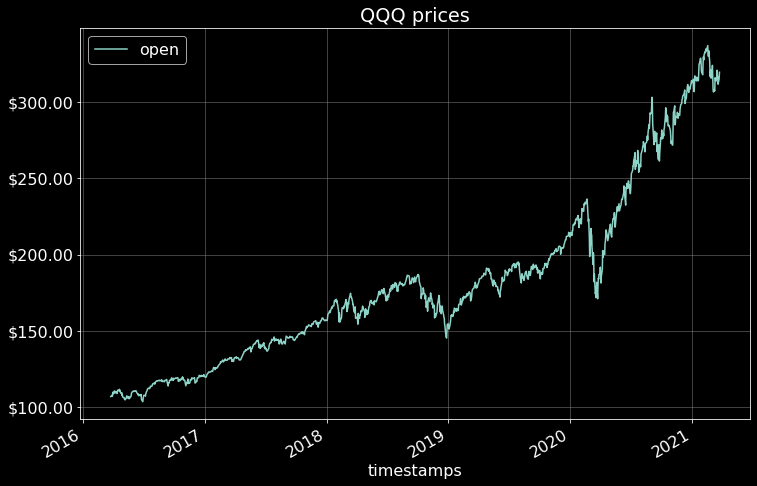

In [4]:
ticker = 'QQQ'
df = getStockData(ticker, "2017", "2020")

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

In [5]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column

Text(0.5, 1.0, 'Prediction Labels')

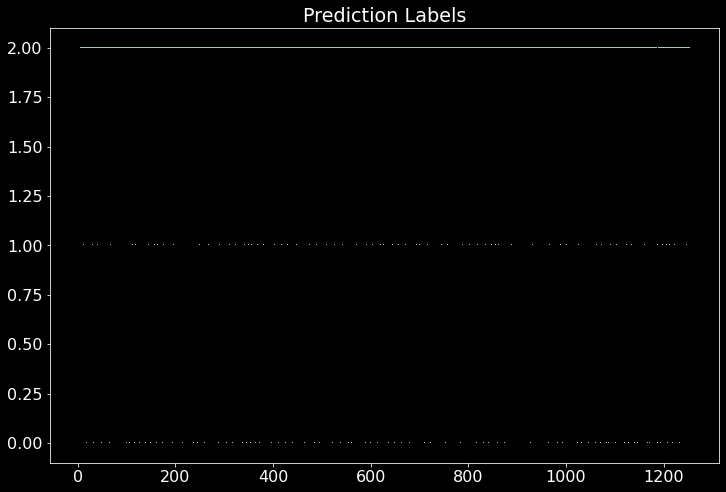

In [6]:
labels = create_labels(df, 'close')
df['labels'] = labels
df['labels'] = df['labels'].fillna(0)

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

# Method Definition for plotting indicators

In [7]:
def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)

# Technical Indicator methods


***Technical Indicators Used:***

*   MACD
*   RSI
*   %K
*   %D
*   ATR
*   DEMA
*   BB
*   WR









# ***RSI***: Relative Strength Index



*   Signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset's price
*   An asset is usually considered overbought when the RSI is above ***`70%`*** and oversold when it is below ***`30%`***
*   A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset
*   The RSI is displayed as an oscillator and can have a reading from 0 to 100.

$$\frac{sin(x)}{x}$$

\begin{equation}
F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx
\end{equation}

\begin{equation}
RSI_{step-one} = 100 - \Bigg[ \frac{100}{1 + \frac{Average Gain}{Average Loss}}\Bigg]
\end{equation}

\begin{equation}
RSI_{step-two} = 100 - \Bigg[ \frac{100}{1 + \frac{(Previous Average Gain*(N-1)) + Current Gain}{(Previous Average Loss*(N-1)) + Current Loss}}\Bigg]
\end{equation}

[Investopedia](https://www.investopedia.com/terms/r/rsi.asp)

<font color='red'> TODO: Code calculation might be slightly wrong </font>



In [8]:
def calculate_rsi(df, iteration):
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0 # Converting to Average Gain
    down[down > 0] = 0 # Converting to Average Loss
    down = abs(down) # Positive Value of Average Loss
    iter_Num_Day_Up_Closes = up.rolling(iteration).mean() # interation # day periods
    iter_Num_Day_Down_Closes = down.rolling(iteration).mean() # interaction # day periods
    relative_strength = iter_Num_Day_Up_Closes / iter_Num_Day_Down_Closes
    df['RSI_'+str(iteration)] = 100 - (100 / (1 + relative_strength))
    df['RSI_'+str(iteration)] = df['RSI_'+str(iteration)].fillna(0)

# ***MACD***: Moving Average Convergance Diverage Momentum


* MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
* The speed of crossovers is also taken as a signal of a market is overbought or oversold.
* MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.

\begin{equation}
MACD =  EMA_{12-period} - EMA_{26-period}
\end{equation}

[Investopedia](https://www.investopedia.com/terms/m/macd.asp)

In [9]:
def calculate_macd(df, iteration):
    df['MACD_'+str(iteration)] = df["close"].ewm(span=12).mean() - df["close"].ewm(span=26).mean()
    df['MACD_'+str(iteration)] = df['MACD_'+str(iteration)].fillna(0)
    #df['Signal Line'] = df['MACD'].ewm(span=9).mean()

# ***EMA***: Exponential Moving Average


*   Moving average that places a greater weight and significance on the most recent data points
*   Traders often use several different EMA lengths, such as <font color='orange'> 10-day </font>, <font color='orange'> 50-day </font>, and <font color='orange'> 200-day </font> moving averages.

\begin{equation}
EMA = \Bigg( Value_{Today}  * \Big( \frac{Smoothing}{1+Days} \Big) + EMA_{Yesterday} * \Big( 1 - \Big( \frac{Smoothing}{1+Days} \Big) \Big) \Bigg)
\end{equation}

\begin{equation}
Weighted Multipler = \frac{Smoothing}{1+Days}
\end{equation}

\begin{equation}
EMA = \Bigg( \Big( Value_{Today} - EMA_{Yesterday} \Big) * \Big( Weighted Multipler \Big) + EMA_{Yesterday} \Bigg)
\end{equation}

*   While there are many possible choices for the smoothing factor, the most common choice is:
  *   <font color='orange'> Smoothing = 2 </font>
  *   That gives the most recent observation more weight. If the smoothing factor is <font color='orange'> increased </font>, more recent observations have <font color='orange'> more influence </font> on the EMA.


[Investopedia Definition](https://www.investopedia.com/terms/e/ema.asp)

[Investopedia Calculation](https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp)



In [10]:
def calculate_ema(df, iteration, windowSize=11):

    if 'EMA_'+str(iteration) in df.columns:
        return df['EMA_'+str(iteration)]
        print("found EMA column")
    else:
        multiplier = (2/(windowSize+1))
        ema_1 = df['close'].rolling(windowSize).sum() / windowSize
        #ema_1 = ema_1.fillna(0)
        df['EMA_'+str(iteration)] = (df['close'] -  ema_1) * multiplier + ema_1 # -> Is this right?
        df['EMA_'+str(iteration)] = df['EMA_'+str(iteration)].fillna(0)
        return df['EMA_'+str(iteration)]

# ***SR***: Stochastic Oscillator



*   The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low
*   Transaction signals are created when the %K crosses through a three-period moving average, which is called the %D.

\begin{equation}
K = \Bigg( \frac{C - L14}{H14-L14} \Bigg) * 100
\end{equation}



*   where:
    *   <font color="orange">C</font> = The most recent closing price
    *   <font color="orange">L14</font> = The lowest price traded of the 14 previous
trading sessions
    *   <font color="orange">H14</font> = The highest price traded during the same 14-day period
    *   <font color="orange">%K</font> = The current value of the stochastic indicator

[Investopedia Definition](https://www.investopedia.com/terms/s/stochasticoscillator.asp)


In [11]:
# SR: Stochastic Oscillator
def calculate_sr(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    # %K is referred to sometimes as the fast stochastic indicator
    fast_K = (df['close']-eleven_low)*100/(eleven_high - eleven_low)
    # The "slow" stochastic indicator is taken as %D = 3-period moving average of %K
    df['%D_'+str(iteration)] = fast_K.rolling(3).mean()
    df['%D_'+str(iteration)] = df['%D_'+str(iteration)].fillna(0)

# ***WR***: Williams Percent Range



*   Williams %R moves between zero and -100.
*   A reading above -20 is overbought.
*   A reading below -80 is oversold.
*   An overbought or oversold reading <font color='red'>doesn't</font> mean the price will reverse. Overbought simply means the price is near the highs of its recent range, and oversold means the price is in the lower end of its recent range.

\begin{equation}
WR  = \Bigg( \frac{Highest High - Close}{Highest High - Lowest Low} \Bigg) * -100
\end{equation}



*   where:
  *   <font color='orange'>Highest High</font> = Highest price in the lookback
period, typically 14 days.
  *   <font color='orange'>Lowest Low</font> = Lowest price in the lookback period, typically 14 days.
  *   <font color='orange'>Close</font> = Most recent closing price


The Williams %R (<font color='green'>***WR***</font>) and the Fast Stochastic Oscillator (<font color='green'>***SR***</font>) end up being <font color='red'>almost the exact same</font> indicator. The only difference between the two is how the indicators are scaled. 

[Investopedia Definition](https://www.investopedia.com/terms/w/williamsr.asp)


In [12]:
def calculate_WR(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    df['WR_'+str(iteration)] = (eleven_high - df['close']) / (eleven_high - eleven_low) * -100
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].rolling(3).mean()
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].fillna(0)

# ***MFI***: Money Flow Index

*   Uses price and volume data for identifying overbought or oversold signals in an asset
*   It can also be used to spot divergences which warn of a trend change in price.
*   The oscillator moves between <font color='orange'>0</font> and <font color='orange'>100</font>.
*   An MFI reading above <font color='orange'>80</font> is considered <font color='orange'>overbought</font> and an MFI reading below <font color='orange'>20</font> is considered <font color='orange'>oversold</font>, although levels of 90 and 10 are also used as thresholds


\begin{equation}
MFI  = \Bigg( 100 - \frac{100}{1 + Money ~Flow ~Ratio} \Bigg)
\end{equation}



*   where:

\begin{equation}
Money ~Flow ~Ratio  = \Bigg(\frac{14~Period ~Positive ~Money ~Flow}{14~Period ~Negative ~Money ~Flow} \Bigg)
\end{equation}

\begin{equation}
Raw ~Money ~Flow  = Typical ~Price * Volume
\end{equation}

\begin{equation}
Typical ~Price  = \Bigg(\frac{High+Low+Close}{3} \Bigg)
\end{equation}



*   When the price advances from one period to the next Raw Money Flow is <font color='lightgreen'>**positive**</font> and it is added to Positive Money Flow. 
*   When Raw Money Flow is <font color='red'>**negative**</font> because the price dropped that period, it is added to Negative Money Flow.




[Investopedia Definition](https://www.investopedia.com/terms/m/mfi.asp)


<font color='red'>TODO: Check that code calculations are correct</font>

In [13]:
# MFI: Money Flow Index
def calculate_mfi(df, iteration):
    price = (df['close'] + df['high'] + df['low']) / 3
    #mf = df['tp'] * df['volume']
    mf = price * df['volume']
    positive_flow = []
    negative_flow = []
    positive_mf = []
    negative_mf = []
    # Loop through typical price calculations
    for i in range(1, len(price)):
        # If current TP > previous TP, mark as positive flow
        if price[i] > price[i-1]:
            positive_flow.append(mf[i-1])
            negative_flow.append(0)
        # If current TP < previous TP, mark as negative flow
        elif price[i] < [i-1]:
            negative_flow.append(mf[i-1])
            positive_flow.append(0)
        # If no change, mark both as zero
        else:
            positive_flow.append(0)
            negative_flow.append(0) 
    for i in range(len(positive_flow) + 1):
        positive_mf.append(sum(positive_flow[i+1-11:i+1]))
    for i in range(len(negative_flow) + 1):
        negative_mf.append(sum(negative_flow[i+1-11:i+1]))
    df['MFI_'+str(iteration)] = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    #df['MFI_'+str(iteration)] = 100 - (100 / (1 + (np.array(positive_mf) + np.array(negative_mf))))
    df['MFI_'+str(iteration)] = df['MFI_'+str(iteration)].fillna(0)

# ***BB***: Bollinger Band



*   When the bands come close together, constricting the moving average, it is called a squeeze.
*   The <font color='red'>mistake</font> most people make is believing that that price hitting or exceeding one of the bands is a signal to buy or sell. 
*   Breakouts provide <font color='red'>no clue</font> as to the direction and extent of future price movement.
*   The upper and lower bands are typically <font color='orange'>2 standard deviations +/-</font> from a 20-day simple moving average, but can be modified.

\begin{equation}
BOLU  = MA(TP, n) + m * σ[TP, n]
\end{equation}

\begin{equation}
BOLD  = MA(TP, n) - m * σ[TP, n]
\end{equation}



*   where:
  *   <font color='orange'>BOLU</font> = Upper Bollinger Band
  *   <font color='orange'>BOLD</font> = Lower Bollinger Band
  *   <font color='orange'>MA</font> = Moving average
  *   <font color='orange'>TP</font> (typical price) = (High + Low + Close) ÷ 3
  *   <font color='orange'>n</font> = Number of days in smoothing period (typically 20)
  *   <font color='orange'>m</font> = Number of standard deviations (typically 2)
  *   <font color='orange'>σ[TP,n]</font> = Standard Deviation over last n periods of TP






In [14]:
def calculate_bb(df, iteration):
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['close'] = df['close']
    atr_df['MA11'] = df['close'].rolling(window=11).mean()
    atr_df['11STD'] = df['close'].rolling(window=11).std()
    atr_df['Upper'] = atr_df['MA11'] + (atr_df['11STD'] * 2) # -> Where is this 2 coming from?
    atr_df['Lower'] = atr_df['MA11'] - (atr_df['11STD'] * 2)
    df['BB_'+str(iteration)] = atr_df[['close','MA11','Upper','Lower']].max(axis=1)
    df['BB_'+str(iteration)] = df['BB_'+str(iteration)].fillna(0)
    plot_indicators(atr_df, ['Upper', 'Lower', 'MA11'], "Bollinger Band", "Days")


# ***ATR***: Average True Range



*   A market volatility indicator used in technical analysis
*   It is typically derived from the <font color='orange'>14-day</font> simple moving average of a series of true range indicators


\begin{equation}
TR  = Max \Big[ (H-L), ~Abs(H-C_{p}), ~Abs(L-C_{p}) \Big]
\end{equation}
\begin{equation}
ATR  = \Big( \frac{1}{n} \Big) \sum_{i=1}^{n}{TR_{i}}
\end{equation}

*   where:
  *   <font color='orange'>$TR_{i}$</font> = A particular true range
  *   <font color='orange'>n</font> = The time period employed
  *   <font color='orange'>$C_{p}$</font> = Previous Close
  *   <font color='orange'>H</font> = Current High
  *   <font color='orange'>L</font> = Current Low



*   Traders can use <font color='orange'>shorter periods</font> than 14 days to generate more trading signals, while <font color='orange'>longer periods</font> have a higher probability to generate fewer trading signals.
*   List item


[Investopia Definition](https://www.investopedia.com/terms/a/atr.asp)




In [15]:
# ATR: Average True Range
def calculate_atr(df, iteration):

    if 'ATR_'+str(iteration) in df.columns:
        return df['ATR_'+str(iteration)]
    else:
        data = df.copy()
        high = df['high']
        low = df['low']
        close = df['close']
        tr_0 = abs(high - low)
        # Creating temporary Dataframe
        atr_df = pd.DataFrame()
        atr_df['tr0'] = abs(high - low)
        atr_df['tr1'] = abs(high - close.shift())
        atr_df['tr2'] = abs(low - close.shift())
        atr_df['TR'] = atr_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        df['ATR_'+str(iteration)] = atr_df['TR'].ewm(alpha=1/11,adjust=False).mean()
        df['ATR_'+str(iteration)] = df['ATR_'+str(iteration)].fillna(0)
        #print(np.where(df['ATR'] < 0))
        return df['ATR_'+str(iteration)]

# ***KC***: Kelter Channel



*   The exponential moving average (EMA) of a Keltner Channel is typically <font color='orange'>20 periods</font>, although this can be adjusted if desired.
*   The upper and lower bands are typically set <font color='orange'>two times</font> the average true range (ATR) above and below the EMA, although the multiplier can also be adjusted based on personal preference.
*   Price reaching the upper Keltner Channel band is <font color='lightgreen'>bullish</font>, while reaching the lower band is <font color='red'>bearish</font>.
*   The angle of the Keltner Channel also aids in identifying the trend direction.

\begin{equation}
Keltner ~Channel ~Middle ~Line = EMA
\end{equation}
\begin{equation}
Keltner ~Channel ~Upper ~Line = EMA + 2 * ATR
\end{equation}
\begin{equation}
Keltner ~Channel ~Lower ~Line = EMA - 2 * ATR
\end{equation}



*   where:
  *   <font color='orange'>EMA</font> = Exponential moving average (typically over <font color='orange'>20</font> periods)
  *   <font color='orange'>ATR</font> = Average True Range (typically over <font color='orange'>10 or 20</font> periods)
*   The bands may also not act as support or resistance and they may seem to have little forecasting ability at all. This could be due to the settings chosen, but there is also <font color='red'>no evidence</font> that the price moving two ATRs or hitting one of the bands will result in a trading opportunity or something significant happening.


[Investopedia](https://www.investopedia.com/terms/k/keltnerchannel.asp)




In [ ]:
# KC: Kelter Channel
def calculate_kc(df, iteration):
    #df['KC'] = df.copy
    #KelChM = pd.Series(((df['high'] + df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChM_' + str(11)) 
    #KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChU_' + str(11))  
    #KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChD_' + str(11))
    atr = calculate_atr(df, iteration)
    temp_df = pd.DataFrame()
    temp_df['middle'] = calculate_ema(df, iteration)
    temp_df['upper'] = temp_df['middle'] + 2 * atr
    temp_df['lower'] = temp_df['middle'] - 2 * atr
    df['KC_'+str(iteration)] = temp_df[['middle','upper','lower']].max(axis=1)
    df['KC_'+str(iteration)] = df['KC_'+str(iteration)].fillna(0)
    #print(np.where(temp_df['middle'] > temp_df['upper']))

# ***DEMA***: Double Exponential Moving Average



*   The Double Exponential Moving Average (DEMA) is one that <font color='orange'>responds more quickly</font> to near-term price changes than a normal exponential moving average (EMA)
*   The DEMA can be used in the same way as other MAs, as long as the trader understands the indicator will <font color='orange'>react quicker and contain less information</font> since it's been smoothed twice. This may require some alteration of strategies.
*   Less lag is <font color='red'>not always</font> a good thing because lag helps <font color='orange'>filter out noise</font>. An indicator with less lag is more prone to reacting to noise or small inconsequential price moves.
*   A longer-term time frame DEMA, e.g. over 100 periods, will be slower to react than a shorter-term time frame DEMA, of e.g. 20 periods.



\begin{equation}
DEMA = 2 * EMA_{N} - EMA ~of ~EMA_{N}
\end{equation}



*   where
  *   <font color='orange'>N</font> = Look-back period

[Investopedia Definition](https://www.investopedia.com/terms/d/double-exponential-moving-average.asp)





In [ ]:
# DEMA: Double Exponential Moving Average
def calculate_dema(df, iteration):
    multiplier = (2/(11+1))
    dema_1 = sum(df['close'],11)
    df['DEMA_'+str(iteration)] = (df['close'] * multiplier) + (dema_1 * (1-multiplier))
    df['DEMA_'+str(iteration)] = df['DEMA_'+str(iteration)].fillna(0)

# ***CCI***: Commodity Channel Index



*   The Commodity Channel Index (CCI) is a technical indicator that measures the difference between the current price and the historical average price.
*   When the CCI is above zero, it indicates the price is above the historic average. Conversely, when the CCI is below zero, the price is below the historic average.
*   The CCI is an unbounded oscillator, meaning it can go higher or lower indefinitely. For this reason, overbought and oversold levels are typically determined for each individual asset by looking at historical extreme CCI levels where the price reversed from.
*   When the CCI moves from negative or near-zero territory to <font color='orange'>above 100</font>, that may indicate the price is starting a new uptrend. Once this occurs, traders can watch for a pullback in price followed by a rally in both price and the CCI to signal a <font color='orange'>buying</font> opportunity.
*   The same concept applies to an emerging downtrend. When the indicator goes from positive or near-zero readings to <font color='orange'>below -100</font>, then a downtrend may be starting. This is a signal to get out of longs or to start watching for <font color='orange'>shorting</font> opportunities.

\begin{equation}
DEMA = \frac{Typical ~Price - MA}{0.015 * Mean ~Deviation}
\end{equation}

*   where:
  *   <font color='orange'>Typical Price</font> = $\sum_{i=1}^{P}{\Big(\frac{High + Low + Close}{3}\Big)}$
  *   <font color='orange'>P</font> = Number of periods
  *   <font color='orange'>MA</font> = Moving Average
  *   <font color='orange'>Moving Average</font> = $\frac{\Big(\sum_{i=1}^{P}{Typical Price}\Big)}{P}$
  *   <font color='orange'>Mean Deviation</font> = $\frac{\Big(\sum_{i=1}^{P}{|Typical ~Price - MA|}\Big)}{P}$

[Investopedia Definition](https://www.investopedia.com/terms/c/commoditychannelindex.asp)





In [ ]:
# CCI: Commodity Channel Index
def calculate_cci(df, iteration):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    df['CCI_'+str(iteration)] = ((typical_price - typical_price.rolling(11).mean())/ (0.015 * typical_price.rolling(11).std()))
    df['CCI_'+str(iteration)] = df['CCI_'+str(iteration)].fillna(0)

In [16]:
# EMV: Ease of Movement Volume
def calculate_emv(df, iteration):
    distance_moved = ((df['high'] + df['low'])/2) - ((df['high'].shift(1) + df['low'].shift(1))/2)
    box_ratio = (df['volume'] / 100000000) / ((df['high'] - df['low']))
    df['EVM_'+str(iteration)] = distance_moved / box_ratio 
    df['EVM_'+str(iteration)] = df['EVM_'+str(iteration)].fillna(0)


# FI: Force Index
def calculate_fi(df, iteration):
    df['FI_'+str(iteration)] = df['close'].diff(11) * df['volume']
    df['FI_'+str(iteration)] = df['FI_'+str(iteration)].fillna(0)


# ROC: Price Rate of Change
def calculate_roc(df, iteration):
    N = df['close'].diff(11)
    D = df['close'].shift(11)
    df['ROC_'+str(iteration)] = N / D
    df['ROC_'+str(iteration)] = df['ROC_'+str(iteration)].fillna(0)


# OBV: On-Balance Volume
def calculate_obv(df, iteration):
    df['OBV_'+str(iteration)] = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'],0)).cumsum()
    df['OBV_'+str(iteration)] = df['OBV_'+str(iteration)].fillna(0)

In [17]:
#calculate_kc(df)

# Run all Technical Indicator methods

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


<Figure size 864x576 with 0 Axes>

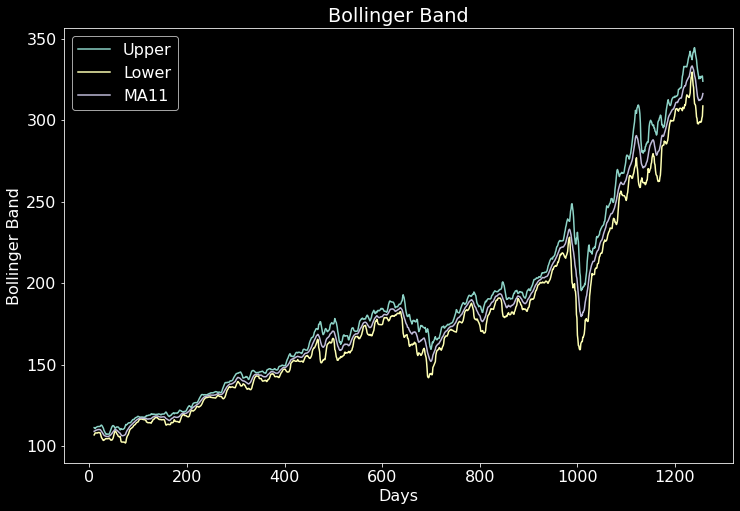

In [18]:
indicator_range = 26

# for x in range(1, indicator_range+1):
#     calculate_macd(df, x)
#     calculate_rsi(df, x)
#     calculate_sr(df, x)
#     calculate_WR(df, x)
#     calculate_ema(df, x)
#     calculate_mfi(df, x)
#     calculate_bb(df, x)
#     calculate_atr(df, x)
#     calculate_kc(df, x)
#     calculate_dema(df, x)
#     calculate_cci(df, x)
#     calculate_emv(df, x)
#     calculate_fi(df, x)
#     calculate_roc(df, x)
#     calculate_obv(df, x)

for x in range(1, indicator_range+1):
    calculate_macd(df, x)
for x in range(6, indicator_range+1):
    calculate_rsi(df, x)
for x in range(1, indicator_range+1):
    calculate_sr(df, x)
for x in range(1, indicator_range+1):
    calculate_WR(df, x)
for x in range(1, indicator_range+1):
    calculate_ema(df, x)
for x in range(1, indicator_range+1):
    calculate_mfi(df, x)
for x in range(1, 2):
    calculate_bb(df, x)
for x in range(1, indicator_range+1):
    calculate_atr(df, x)
for x in range(1, indicator_range+1):
    calculate_kc(df, x)
for x in range(1, indicator_range+1):
    calculate_dema(df, x)
for x in range(1, indicator_range+1):
    calculate_cci(df, x)
for x in range(1, indicator_range+1):
    calculate_emv(df, x)
for x in range(1, indicator_range+1):
    calculate_fi(df, x)
for x in range(1, indicator_range+1):
    calculate_roc(df, x)
for x in range(1, indicator_range+1):
    calculate_obv(df, x)

# Plot charts for Technical Indicators

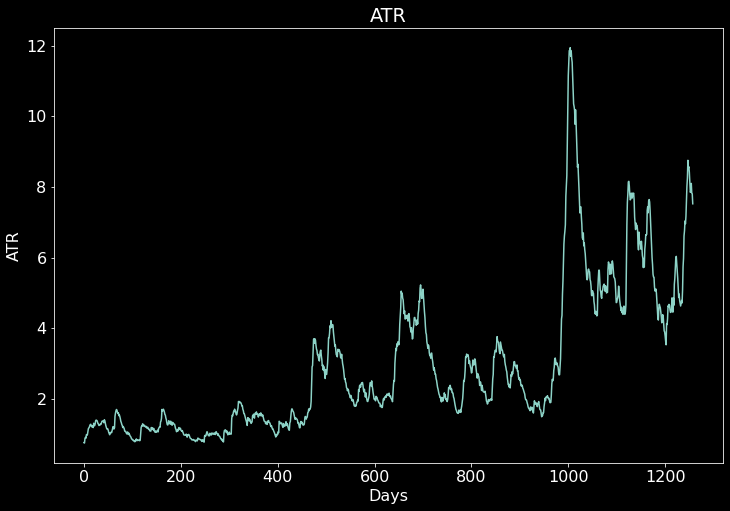

In [19]:

#plot_indicators(df, ['MACD_1'], "MACD", "Days")
#plot_indicators(df, ["EMA_10", "close"], "EMA", "Days")
#plot_indicators(df, "RSI_26", "RSI", "Days")
plot_indicators(df, "ATR_10", "ATR", "Days")

# Normalization of the Data

In [20]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

pd.options.display.max_columns = 20

#print(df.columns)
#list_features = list(df.loc[:, 'open': 'OBV_'+str(indicator_range)].columns) # Gets the names of all the columns from MACD to RSI
list_features = list(df.loc[:, ~df.columns.isin(['timestamps', 'labels'])].columns)
print('Total number of features', len(list_features))
print("Columns:", list_features)


# df.loc[:, 'MACD':'RSI'].values: -> Data used to create 'x_train' and 'x_test'
# df['labels'].values: -> Data used to create 'y_train' and 'y_test'
#print(df.loc[:, 'MACD':'OBV'])
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open': 'OBV_'+str(indicator_range)].values, df['labels'].values, train_size=0.8, test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

if 0.7*x_train.shape[0] < 2500:
    # If training dataset is small, it increases the percentage of training
    train_split = 0.8
else:
    train_split = 0.7

print('train_split =', train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)

mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
#print(x_train[0])
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Total number of features 365
Columns: ['open', 'high', 'low', 'close', 'volume', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', '%D_21', '%D_22', '%D_23', '%D_24', '%D_25', '%D_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'WR_21', 'WR_22', 'WR_23', 'WR_24', 'WR_

# Feature Selection

*3rd deviation from original paper*

In [21]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

num_features = 225  # should be a perfect square
selection_method = 'anova'
topk = 320 if selection_method == 'all' else num_features

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)  # x_train[:, feat_idx] will give you training data with desired features

('volume', 'MACD_1', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', '%D_21', '%D_22', '%D_23', '%D_24', '%D_25', '%D_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'WR_21', 'WR_22', 'WR_23', 'WR_24', 'WR_25', 'WR_26', 'EMA_1', 'MFI_2', 'MFI_3', 'MFI_4', 'MFI_5', 'MFI_6', 'MFI_7', 'MFI_8', 'MFI_9', 'MFI_10', 'MFI_11', 'MFI_12', 'MFI_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


# Method: *reshape_as_image*

In [22]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

# Reshaping the Data as an Image

In [23]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
print("x_cv shape:", x_cv.shape)

final shape of x, y train/test (804, 15, 15, 3) (804,) (252, 15, 15, 3) (252,)
x_cv shape: (202, 15, 15, 3)


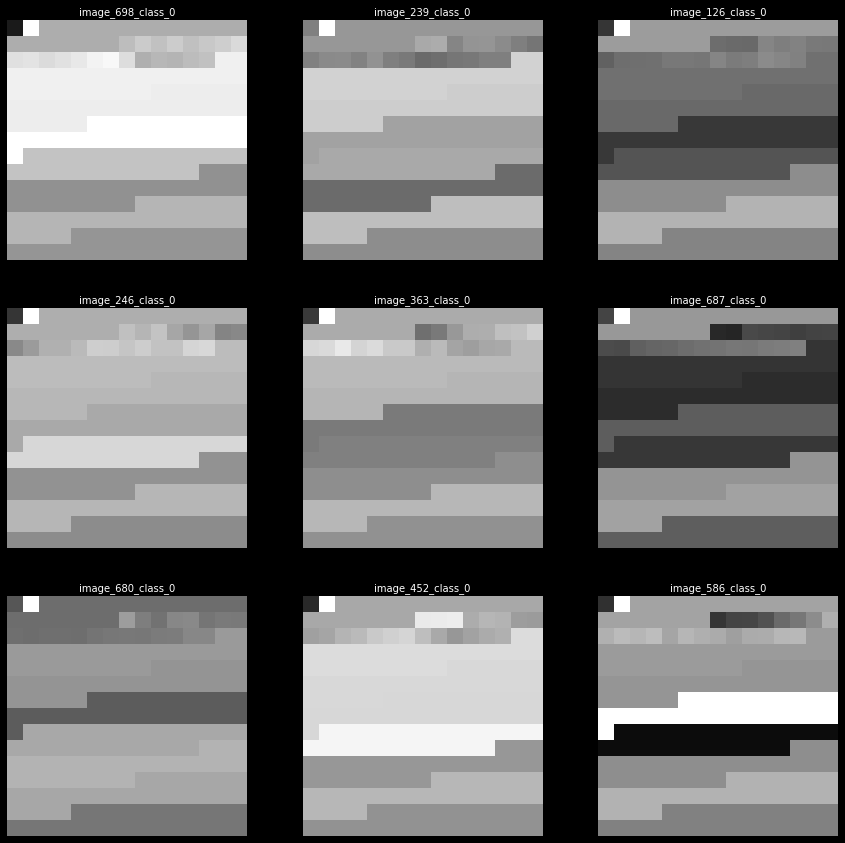

In [24]:
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

# Current Class Imbalance

Sell = 0, Buy = 1, Hold = 2

In [25]:
class_labels, class_count = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {:.3f}%, class 1 = {:.3f}%, class 2 = {:.3f}%".format(class_count[0]/len(y_train)*100, class_count[1]/len(y_train)*100, class_count[2]/len(y_train)*100))

percentage of class 0 = 6.716%, class 1 = 5.473%, class 2 = 87.811%


In [26]:
print(x_train[0].shape[0])
print(x_train[0].shape[1])
print(x_train[0].shape[2])
print(x_train.shape)

15
15
3
(804, 15, 15, 3)


# Building Convolutional Neural Network

In [27]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(filters=32, 
           kernel_size=3, 
           strides=1, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True,
           kernel_initializer='glorot_uniform',
           input_shape=(x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2])),
    Dropout(rate=0.2),
    Conv2D(filters=64, 
           kernel_size=3, 
           strides=2, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True, 
           kernel_initializer='glorot_uniform'),
    MaxPool2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(units=128, 
          activation='relu'),
    Dropout(rate=0.3),
    Dense(units=3, activation='softmax')
])

In [28]:
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Choosing 'Sample Weights' for the model to pay more attention to

In [29]:
from sklearn.utils.class_weight import compute_class_weight

def get_sample_weights(y):
        """
        calculate the sample weights based on class weights. Used for models with
        imbalanced data and one hot encoding prediction.
        params:
            y: class labels as integers
        """

        y = y.astype(int)  # compute_class_weight needs int labels
        class_weights = compute_class_weight('balanced', np.unique(y), y)

        print("real class weights are {}".format(class_weights), np.unique(y))
        print("value_counts", np.unique(y, return_counts=True))
        sample_weights = y.copy().astype(float)
        for i in np.unique(y):
            sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

        return sample_weights

sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, len(y_train), 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])
print(sample_weights.shape)

real class weights are [4.96296296 6.09090909 0.3796034 ] [0 1 2]
value_counts (array([0, 1, 2]), array([ 54,  44, 706]))
Test sample_weights
[2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2.]
[0.3796034  0.3796034  0.3796034  0.3796034  0.3796034  0.3796034
 0.3796034  0.3796034  0.3796034  6.09090909 0.3796034  0.3796034
 0.3796034  0.3796034  0.3796034  0.3796034  0.3796034  0.3796034
 0.3796034  0.3796034  0.3796034  0.3796034  0.3796034  0.3796034
 0.3796034  0.3796034  0.3796034  6.09090909 0.3796034  0.3796034 ]
(804,)


# Compiling Model



*   *Optimizer:* Adam
*   *Loss:* Sparse Categorical Crossentropy

<font color="red"> TODO: Sparse Categorical Crossentropy vs Categorical_Entropy </font>



In [30]:
from tensorflow.keras import optimizers

optimizer_model = 'adam'
learning_rate = 0.001

if optimizer_model == 'rmsprop':
    optimizer = optimizers.RMSprop(lr=learning_rate)
elif optimizer_model == 'sgd':
    optimizer = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
elif optimizer_model == 'adam':
    optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
import os

best_model_path = os.path.join('.', 'best_model_keras')

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=100, 
    min_delta=0.0001
    )

rlp = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.02, 
    patience=20, 
    verbose=1, 
    mode='min', 
    min_delta=0.001, 
    cooldown=1, 
    min_lr=0.001
    )

mcp = ModelCheckpoint(
    best_model_path, 
    monitor='val_f1_metric', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max', 
    save_freq=1
    )

In [32]:
%%time

history = model.fit(
    x_train, 
    y_train, 
    epochs=30, 
    verbose=1, 
    batch_size=64, 
    shuffle=True, 
    validation_data=(x_cv, y_cv), 
    callbacks=[mcp, rlp, es], 
    sample_weight=sample_weights
    )

Epoch 1/30
13/13 [==============================] - 2s 82ms/step - loss: 1.0393 - accuracy: 0.5671 - f1_metric: 4.6724 - val_loss: 1.1307 - val_accuracy: 0.0891 - val_f1_metric: 5.5975
Epoch 2/30
13/13 [==============================] - 1s 41ms/step - loss: 0.9671 - accuracy: 0.3684 - f1_metric: 4.8860 - val_loss: 1.0918 - val_accuracy: 0.1188 - val_f1_metric: 5.3625
Epoch 3/30
13/13 [==============================] - 1s 40ms/step - loss: 1.1253 - accuracy: 0.2188 - f1_metric: 3.8771 - val_loss: 0.8328 - val_accuracy: 0.7772 - val_f1_metric: 3.8983
Epoch 4/30
13/13 [==============================] - 1s 40ms/step - loss: 0.8708 - accuracy: 0.5754 - f1_metric: 2.7208 - val_loss: 1.0821 - val_accuracy: 0.2426 - val_f1_metric: 2.7282
Epoch 5/30
13/13 [==============================] - 1s 40ms/step - loss: 0.7646 - accuracy: 0.4503 - f1_metric: 2.2843 - val_loss: 0.7830 - val_accuracy: 0.6980 - val_f1_metric: 1.7301
Epoch 6/30
13/13 [==============================] - 1s 41ms/step - loss: 0.

In [33]:
eval = model.evaluate(x=x_test, y=y_test, batch_size=64, verbose=1)

4/4 [==============================] - 0s 8ms/step - loss: 3.7873e-04 - accuracy: 1.0000 - f1_metric: 0.9651
